In [ ]:
import numpy as np
from scipy.io import loadmat
import keras
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-06-21 05:22:11--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  18.4MB/s    in 10s     

2022-06-21 05:22:21 (17.1 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2022-06-21 05:22:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  19.2MB/s    in 3.8s    

2022-06-21 05:22:25 (16.3 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
train_ds = loadmat('train_32x32.mat')
test_ds  = loadmat('test_32x32.mat')

In [ ]:
train_X, train_y = train_ds['X'], train_ds['y']
test_X, test_y = test_ds['X'], test_ds['y']

In [ ]:
train_X.shape

(32, 32, 3, 73257)

In [ ]:
train_X = np.rollaxis(train_X,3)
test_X = np.rollaxis(test_X,3)

train_X.shape

(73257, 32, 32, 3)

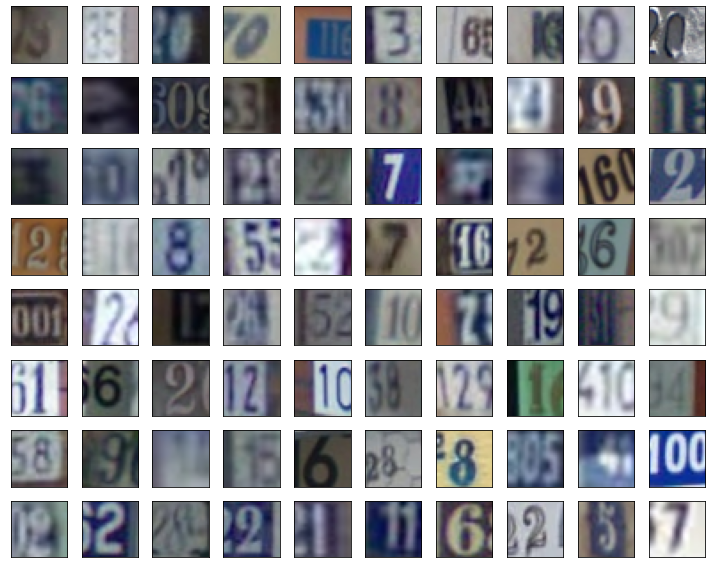

In [ ]:
sample_imgs = train_X[np.random.choice(len(train_X), size = 80, replace = False)]

plt.figure(figsize = (10,8))
for i in range(80):
  plt.subplot(8,10,i+1)
  plt.imshow(sample_imgs[i])
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
def preprocess(x):
  return (x/255)*2 -1

In [ ]:
def deprocess(x):
  return np.uint8((x+1)/2*255)

In [ ]:
train_X = preprocess(train_X)
train_y = preprocess(train_y)

In [ ]:
def generator(latent_size, alpha):
  model = Sequential()
  model.add(Dense(4*4*512, input_shape = (latent_size,)))
  model.add(Reshape((4,4,512)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = alpha))
  model.add(Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = alpha))
  model.add(Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = alpha))
  model.add(Conv2DTranspose(3, kernel_size = 5, strides = 2, padding = 'same', activation = 'tanh'))
  return model

In [ ]:
def discriminator(alpha):
  model = Sequential()
  model.add(Conv2D(64,kernel_size=5, strides=2,padding='same', input_shape = (32,32,3)))
  model.add(LeakyReLU(alpha =alpha))
  model.add(Conv2D(128,kernel_size=5, strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha =alpha))
  model.add(Conv2D(256,kernel_size=5, strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha =alpha))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  return model


In [ ]:
def dcgan(latent_size, g_lr, d_lr, g_b1, d_b1, alpha):
  K.clear_session()
  gen = generator(latent_size, alpha)
  disc = discriminator(alpha)
  disc.compile(optimizer = Adam(learning_rate = d_lr, beta_1 = d_b1), loss = 'binary_crossentropy')
  gan = Sequential([gen,disc])
  gan.compile(optimizer = Adam(learning_rate = g_lr, beta_1 = g_b1), loss = 'binary_crossentropy')
  return gan, gen, disc 

In [ ]:
def latent_space(n_samples, latent_size):
  return np.random.normal(loc=0, scale=1, size=(n_samples, latent_size))

In [ ]:
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

In [ ]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [ ]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

In [ ]:
def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
def train(g_lr, g_b1, d_lr, d_b1, alpha, smooth = 0.1, latent_size = 100, epochs = 25, batch_size = 128, eval_size = 16, show_details=True):
  y_train_real, y_train_fake = make_labels(batch_size)
  y_eval_real,  y_eval_fake  = make_labels(eval_size)

  gan, gen, disc = dcgan(latent_size, g_lr, d_lr, g_b1, d_b1, alpha)

  losses = []
  for e in range(epochs):
    for i in range(len(train_X) // batch_size):
      X_batch_real = train_X[i*batch_size:(i+1)*batch_size]

      latent_samples = latent_space(batch_size, latent_size)
      X_batch_fake = gen.predict_on_batch(latent_samples)

      make_trainable(disc,True)
      disc.train_on_batch(X_batch_real,y_train_real * (1-smooth))
      disc.train_on_batch(X_batch_fake,y_train_fake)

      make_trainable(disc,False)
      gan.train_on_batch(latent_samples,y_train_real)

      X_eval_real = test_X[np.random.choice(len(test_X), eval_size, replace=False)]
      latent_samples = latent_space(eval_size, latent_size)
      X_eval_fake = gen.predict_on_batch(latent_samples)

      d_loss  = disc.test_on_batch(X_eval_real, y_eval_real)
      d_loss += disc.test_on_batch(X_eval_fake, y_eval_fake)
      g_loss  = gan.test_on_batch(latent_samples, y_eval_real)

      losses.append((d_loss, g_loss))

      print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(e+1, epochs, d_loss, g_loss))

      if (e+1) % 5 == 0: 
        show_images(X_eval_fake[:10])
      
  if show_details:
        show_losses(losses)
        show_images(generator.predict(latent_space(80, latent_size)))    
  return generator

In [ ]:
train(g_lr = 0.0001, g_b1 = 0.5, d_lr=0.001, d_b1=0.5, alpha=0.2)

Output hidden; open in https://colab.research.google.com to view.